In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pylab import *
import os

torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

(<matplotlib.image.AxesImage at 0x142a5e010>, 5)

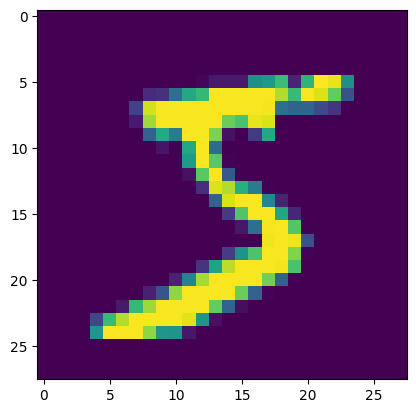

In [3]:
imshow(train_dataset[0][0][0]), train_dataset[0][1]

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = x.view(-1, 784) # flatten the input
        out = self.relu(self.fc1(out))
        out = self.drop(out)
        out = self.fc2(out)
        return out

In [5]:
# Data Loader 
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [6]:
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print('Epoch: %d, Loss: %.3f' % (epoch+1, running_loss/(i+1)))

/Users/saidev/pyenvs/ml-env/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1, Loss: 0.371
Epoch: 2, Loss: 0.179
Epoch: 3, Loss: 0.133
Epoch: 4, Loss: 0.106
Epoch: 5, Loss: 0.093
Epoch: 6, Loss: 0.080
Epoch: 7, Loss: 0.071
Epoch: 8, Loss: 0.063
Epoch: 9, Loss: 0.059
Epoch: 10, Loss: 0.053


In [8]:
def evaluate_model(model):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            predicted = torch.argmax(outputs)
            total_correct += (predicted == labels).sum().item()
            total_samples += len(labels)
        
        accuracy = total_correct / total_samples
        print("Accuracy:", accuracy)

In [9]:
evaluate_model(model)

Accuracy: 0.9797


In [10]:
# Save the original weights
torch.save(model.state_dict(), 'mnist_model.pth')

## Quantization

In [11]:
from torch.quantization import quantize_dynamic

In [16]:
torch.backends.quantized.engine = 'qnnpack'

In [17]:
quantized_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
torch.save(quantized_model.state_dict(), 'quantized_mnist_model.pth')

In [18]:
quantized_model

Net(
  (fc1): DynamicQuantizedLinear(in_features=784, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (relu): ReLU()
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc2): DynamicQuantizedLinear(in_features=128, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

### Comparison

In [19]:
original_size = os.path.getsize('mnist_model.pth')
print(f"Original weights size: {original_size/1e3} kb")

quantized_size = os.path.getsize('quantized_mnist_model.pth')
print(f"Quantized weights size: {quantized_size/1000} kb")

Original weights size: 409.2 kb
Quantized weights size: 105.704 kb


In [20]:
evaluate_model(model)

Accuracy: 0.9797


In [21]:
evaluate_model(quantized_model)

[W qlinear_dynamic.cpp:247] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Accuracy: 0.9795
